# Time Series Clustering using DTW KMeans

In this notebook, we will train a KMeans Clustering algorithm based on DTW distances between Time Series data.

We leverage the tslearn library for clustering. More details are available at: https://tslearn.readthedocs.io/en/stable/index.html

The data used in this analysis is publicly available via UCI Archive under Online Retail II Data Set: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

This dataset was cleaned and preprocessed using the (Optional) Data Cleaning and Preparation notebook. The reader may directly use the cleaned data included in the repository under: './data/df_pivoted.csv.zip' for running this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
df_pivoted = pd.read_csv('./data/df_pivoted.csv.zip', low_memory=False)

In [3]:
# prepare data to laod to tslearn time_series_dataset object
df_pivoted.set_index('StockCode', inplace=True)

print(df_pivoted.shape, df_pivoted.columns)

df_pivoted.head()

(4605, 374) Index(['2009-12-01 00:00:00', '2009-12-02 00:00:00', '2009-12-03 00:00:00',
       '2009-12-04 00:00:00', '2009-12-05 00:00:00', '2009-12-06 00:00:00',
       '2009-12-07 00:00:00', '2009-12-08 00:00:00', '2009-12-09 00:00:00',
       '2009-12-10 00:00:00',
       ...
       '2010-11-30 00:00:00', '2010-12-01 00:00:00', '2010-12-02 00:00:00',
       '2010-12-03 00:00:00', '2010-12-04 00:00:00', '2010-12-05 00:00:00',
       '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00',
       '2010-12-09 00:00:00'],
      dtype='object', length=374)


,2009-12-01 00:00:00,2009-12-02 00:00:00,2009-12-03 00:00:00,2009-12-04 00:00:00,2009-12-05 00:00:00,2009-12-06 00:00:00,2009-12-07 00:00:00,2009-12-08 00:00:00,2009-12-09 00:00:00,2009-12-10 00:00:00,...,2010-11-30 00:00:00,2010-12-01 00:00:00,2010-12-02 00:00:00,2010-12-03 00:00:00,2010-12-04 00:00:00,2010-12-05 00:00:00,2010-12-06 00:00:00,2010-12-07 00:00:00,2010-12-08 00:00:00,2010-12-09 00:00:00
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,12.0,0.0,7.0,73.0,0.0,49.0,2.0,12.0,0.0,1.0,...,12.0,60.0,1.0,8.0,0.0,1.0,25.0,8.0,13.0,44.0
10080,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10109,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,60.0,10.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,6.0,...,10.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,0.0
10125,5.0,0.0,0.0,46.0,0.0,8.0,20.0,1.0,22.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,0.0


## DTW KMeans Clustering

In [4]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [5]:
%%time

# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

(4605, 374, 1) (4605, 374, 1)
CPU times: user 489 ms, sys: 50.5 ms, total: 539 ms
Wall time: 534 ms


In [6]:
# create required directory structure
dir_paths = ['./tsl', './tsl/models', './tsl/plots']

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

### Perform clustering

With 12 cores, the clustering operation can take roughly half an hour. Your mileage may vary depending on your machine's configuration.

In [7]:
%%time

# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 3
NUM_CPU = 12

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=NUM_CPU,
                        random_state=0)

y_pred = model.fit_predict(X_train)

model.to_pickle(f"./tsl/models/{algo}.pkl")

CPU times: user 1h 43min 55s, sys: 1h 3min 1s, total: 2h 46min 56s
Wall time: 29min 13s


In [8]:
# backup clustering results
np.save(f"./data/tls_{algo}_cluster_labels", y_pred)

Let us plot the different clusters to visually inspect the homogeneity of the cluster composition.

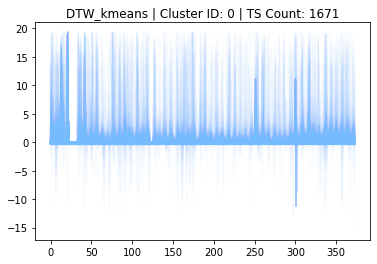

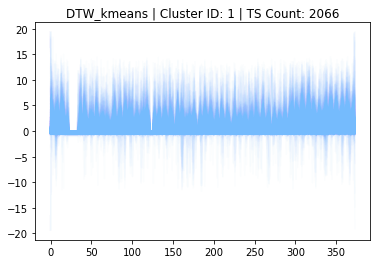

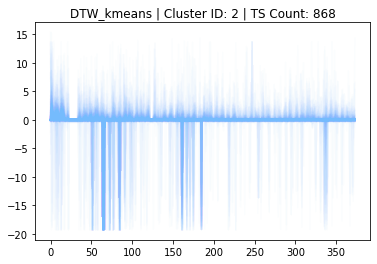

CPU times: user 11.1 s, sys: 26.8 ms, total: 11.1 s
Wall time: 11.3 s


In [9]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.025)
    fig.savefig(f"./tsl/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

## Generate TTS for different clusters

We can now split the TTS into clusters based on the labels for the different items

In [11]:
# convert data to TTS format expected by Forecast service
df_pivoted.reset_index(inplace=True)

df_tts = pd.melt(df_pivoted, id_vars=['StockCode'])
df_tts.columns = ['item_id', 'timestamp', 'target_value']
df_tts['timestamp'] = df_tts['timestamp'].str[:10]  # keep only the date part

print(df_tts.shape, df_tts.dtypes)

df_tts.head()

(1722270, 3) item_id          object
timestamp        object
target_value    float64
dtype: object


,item_id,timestamp,target_value
0,10002,2009-12-01,12.0
1,10080,2009-12-01,0.0
2,10109,2009-12-01,0.0
3,10120,2009-12-01,60.0
4,10125,2009-12-01,5.0


In [12]:
min(df_tts['timestamp']), max(df_tts['timestamp'])

('2009-12-01', '2010-12-09')

### Train - Hold-out Split

Hold-out set offers a way for verifying model performance on unseen data. With this dataset, we are looking to forecast a week out (Forecast Horizon = 1 Week) and therefore leave out a week worth of data out from the TTS as holdout set.

In [13]:
df_train = df_tts[df_tts['timestamp'] < '2010-12-03']
df_test = df_tts[df_tts['timestamp'] > '2010-12-02']

df_tts.shape, df_train.shape, df_test.shape

((1722270, 3), (1690035, 3), (32235, 3))

In [14]:
# verify that we have adequate coverage across train and test
df_tts.item_id.nunique(), df_train.item_id.nunique(), df_test.item_id.nunique()

(4605, 4605, 4605)

## Split data into clusters

In [15]:
# if restarting, reload the cluster labels
y_pred = np.load(f"./data/tls_{algo}_cluster_labels.npy")

print(y_pred)

[1 0 2 ... 2 0 0]


In [18]:
# lookup dataframe with item_ids and corresponding labels
df_lbl = pd.DataFrame()
df_lbl['item_id'] = df_pivoted['StockCode']
df_lbl['label'] = y_pred

df_lbl.shape, df_lbl.dtypes

((4605, 2),
 item_id    object
 label       int64
 dtype: object)

In [20]:
# merge labels back to the TTS
df_mrg = df_train.merge(df_lbl, how='left')

print(df_mrg.shape, df_train.shape)

(1690035, 4) (1690035, 3)


In [21]:
df_mrg.sample(5)

,item_id,timestamp,target_value,label
1412154,16244B,2010-10-03,0.0,0
625843,85131C,2010-04-15,0.0,0
802738,22272,2010-05-24,2.0,1
285289,90065A,2010-01-31,0.0,2
1178426,85123b,2010-08-13,0.0,0


In [22]:
# create required directory structure
dir_paths = ['./train', './train/cls_01', './train/cls_02', './train/cls_03']

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [23]:
# split and save TTS
record_count = 0
for i in range(N_CLUSTERS):
    df_tmp = df_mrg[['item_id', 'timestamp', 'target_value']][df_mrg['label']==i]
    df_tmp.to_csv(f"./train/cls_0{i+1}/tts_{i+1}.csv", header=None, index=None)
    record_count += df_tmp.shape[0]
    
assert record_count == df_mrg.shape[0]

### Processing Complete

These TTS files can now be uploaded to S3 and used to train Forecast models as demonstrated in the following notebooks: https://github.com/aws-samples/amazon-forecast-samples/tree/master/notebooks/basic/Tutorial